Importing Packages:

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

Load Dataset

In [ ]:
import tarfile

# Replace '/content/aclImdb_v1.tar' with the correct path to your tar file
tar_path = '/content/aclImdb_v1.tar'

# Extract the contents of the tar file
with tarfile.open(tar_path, 'r') as tar:
    tar.extractall('/content/')  # Extract to the /content/ directory


In [ ]:
def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
    imdb_data_path = os.path.join(data_path, 'aclImdb')

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)
    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

In [ ]:
train_df,test_df=load_imdb_sentiment_analysis_dataset('/content/',seed=123)

In [ ]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

In [ ]:
print('Number of samples:',len(train_df[0]))
print('Number of Class:',set(train_df[1]))
print('Number of words per sample:',get_num_words_per_sample(train_df[0]))

Number of samples: 25000
Number of Class: {0, 1}
Number of words per sample: 174.0


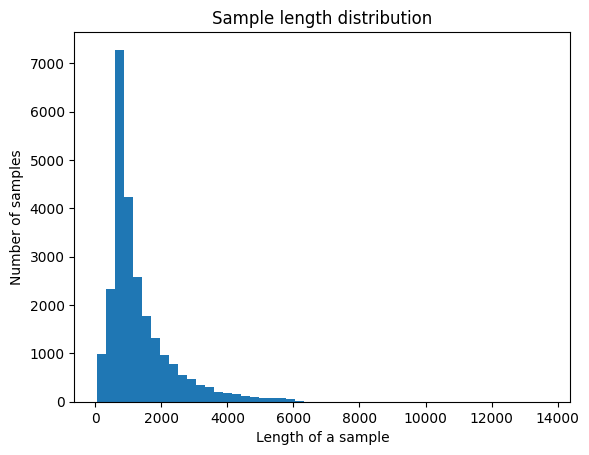

In [ ]:
plot_sample_length_distribution(train_df[0])

In [ ]:
print('the number of samples/number of words per sample ratio:',len(train_df[0])/get_num_words_per_sample(train_df[0]))

the number of samples/number of words per sample ratio: 143.67816091954023


In [ ]:
def get_num_classes(labels):
    """Gets the total number of classes.

    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)

    # Returns
        int, total number of classes.

    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes

In [ ]:
get_num_classes(train_df[1])

2

In [ ]:
import pandas as pd
data={
    'Sentence':train_df[0],
    'Label':train_df[1],
}
df=pd.DataFrame(data)

In [ ]:
df.head(10)

,Sentence,Label
0,POSSIBLE SPOILERS<br /><br />The Spy Who Shagg...,0
1,"The long list of ""big"" names in this flick (in...",0
2,Bette Midler showcases her talents and beauty ...,1
3,Great movie when I saw it. Have to say one of ...,1
4,Although it's most certainly politically incor...,1
5,A pointless movie with nothing but gratuitous ...,0
6,The reason the DVD releases of this film are i...,0
7,as an actor I really like independent films bu...,0
8,Director Douglas Sirk once said `there's a ver...,1
9,For those who think of Dame May Witty as the k...,1


In [ ]:
data1={
    'Sentence':test_df[0],
    'Label':test_df[1],
}
df1=pd.DataFrame(data1)

Feature Engineering

In [ ]:
#convert Text into Vector

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [ ]:
train_df_vec,test_df_vec=ngram_vectorize(df['Sentence'],df['Label'],df1['Sentence'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


In [ ]:
train_df_vec.shape[1:]

(20000,)

## Training the Model


In [ ]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [ ]:
_get_last_layer_units_and_activation(2)

(1, 'sigmoid')

In [ ]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
import tensorflow as tf
from keras.optimizers import Adam

In [ ]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model


In [ ]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val = ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    model.compile(optimizer=Adam(learning_rate=0.001), loss=loss, metrics=['acc'])
    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('IMDb_mlp_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

In [ ]:
train_ngram_model((train_df,test_df))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


ValueError: ignored

In [ ]:
 tf.keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
from tensorflow.keras.optimizers import Adam
